In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import pytz

In [2]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns if needed

In [3]:
# Load the data
prices_df = pd.read_csv('day_ahead_energy_prices.csv', parse_dates=[0], index_col=0)
mix_df = pd.read_csv('daily_market_mix.csv', header=None, names=['Date', 'Energy Source', 'Share'])
# Convert the 'Date' column to datetime format
mix_df['Date'] = pd.to_datetime(mix_df['Date'], format='%Y_%m_%d')

# Pivot data: use 'Energy Source' as column names and transform share values
mix_df = mix_df.pivot(index='Date', columns='Energy Source', values='Share')
mix_df.fillna(0, inplace=True)
mix_df = mix_df.reset_index()

# Repeat each daily row 24 times for hourly entries
hourly_mix_df = mix_df.loc[mix_df.index.repeat(24)].reset_index(drop=True)

# Add an hour column to each repeated day
hourly_mix_df['Hour'] = list(range(24)) * (len(hourly_mix_df) // 24)

# Combine 'Date' and 'Hour' into a full datetime and set timezone
hourly_mix_df['Datetime'] = hourly_mix_df['Date'] + pd.to_timedelta(hourly_mix_df['Hour'], unit='h')
hourly_mix_df['Datetime'] = hourly_mix_df['Datetime'].dt.tz_localize('UTC')

# Check if the timezone is not UTC and convert if necessary
if hourly_mix_df['Datetime'].dt.tz != 'UTC':
    hourly_mix_df['Datetime'] = hourly_mix_df['Datetime'].dt.tz_convert('UTC')

# Set 'Datetime' as the index
hourly_mix_df.set_index('Datetime', inplace=True)

# Drop unnecessary columns
hourly_mix_df = hourly_mix_df.drop(['Date', 'Hour'], axis=1)

prices_df.rename(columns={'hourly day-ahead energy price': 'Price'}, inplace=True)
prices_df.index = prices_df.index.tz_localize(None)

# Define start and end dates as timezone-aware (in UTC)
start_date = datetime(2024, 5, 1, tzinfo=pytz.UTC)
end_date = datetime(2024, 10, 29, tzinfo=pytz.UTC)

# Ensure the index of prices_df is timezone-aware in UTC
if prices_df.index.tz is None:
    prices_df.index = prices_df.index.tz_localize('UTC')

# Ensure the index of hourly_mix_df is timezone-aware in UTC
if hourly_mix_df.index.tz is None:
    hourly_mix_df.index = hourly_mix_df.index.tz_localize('UTC')

# Now filter based on the timezone-aware start and end dates
filtered_prices_df = prices_df[(prices_df.index >= start_date) & (prices_df.index <= end_date)]
filtered_mix_df = hourly_mix_df[(hourly_mix_df.index >= start_date) & (hourly_mix_df.index <= end_date)]

# Merge the data
data = pd.merge(filtered_prices_df, filtered_mix_df, left_index=True, right_on='Datetime')
# print(data)

In [4]:
# Separate features and labels
X = data.drop(columns=['Price'])
y = data['Price'].tolist()

# Split data for training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# Prediction and evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

RMSE: 39.501459313578124


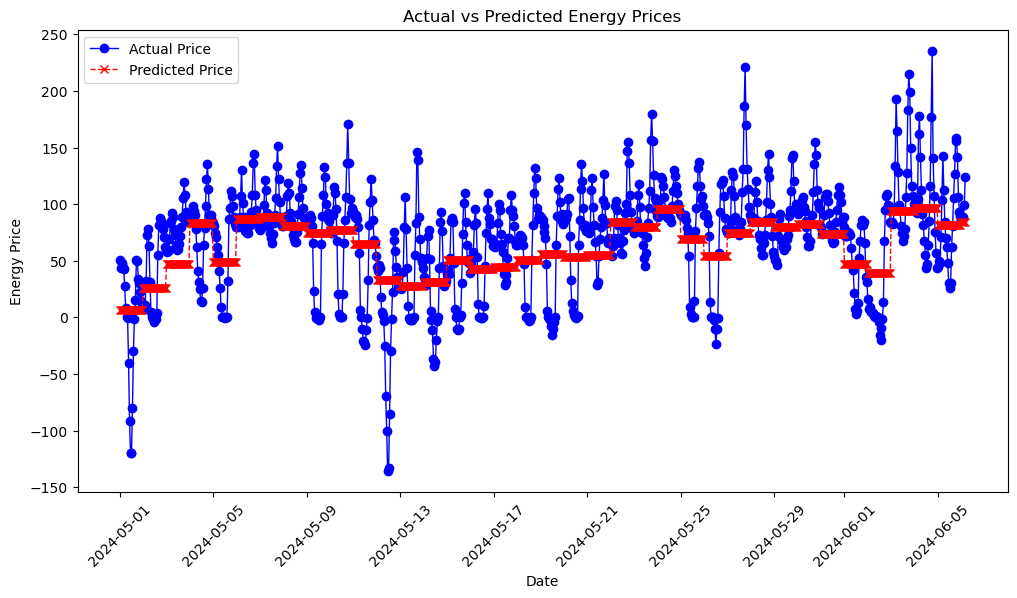

In [5]:
# Visualization of actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual Price', color='blue', marker='o', linestyle='-', linewidth=1)
plt.plot(X_test.index, y_pred, label='Predicted Price', color='red', marker='x', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Energy Price')
plt.title('Actual vs Predicted Energy Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()

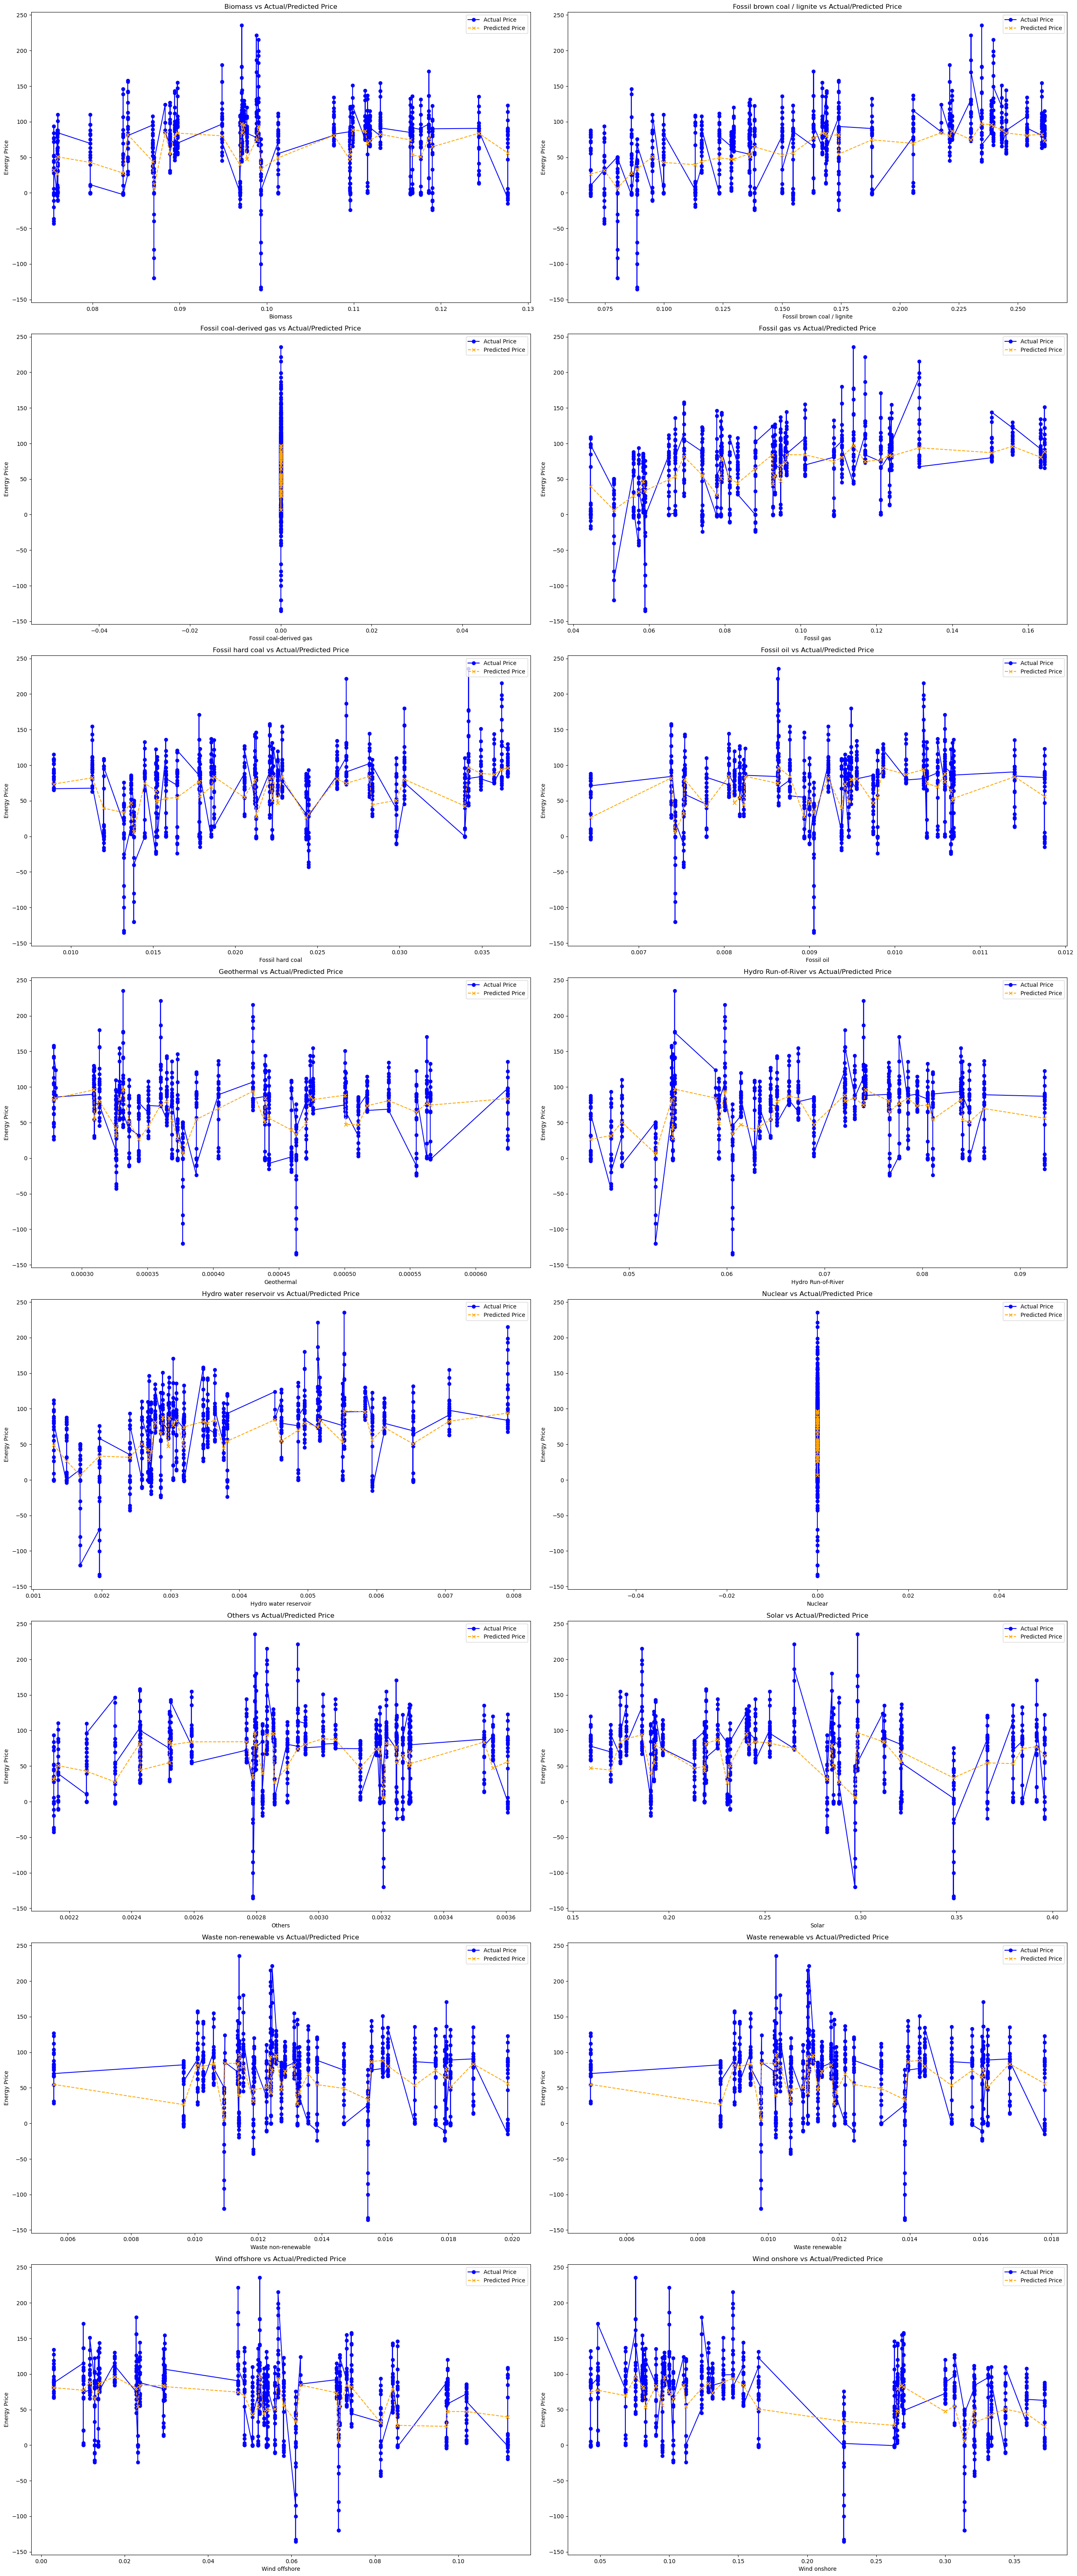

In [11]:
# Set display width to 100% for the notebook cell
display(HTML("<style>.container { width:100% !important; }</style>"))

# Visualization settings
num_features = len(X.columns)
fig, axes = plt.subplots(nrows=(num_features // 2) + 1, ncols=2, figsize=(27, num_features * 4.5))

# Plot for each feature
for i, feature in enumerate(X.columns):
    # Get data for the current feature
    X_test_feature = X_test[feature].sort_values()  # Sort data for a smoother line
    y_test = pd.Series(y_test, index=X_test.index)
    y_test_sorted = y_test.loc[X_test_feature.index]
    y_pred_sorted = pd.Series(y_pred, index=y_test.index).loc[X_test_feature.index]

    # Plot actual prices (blue solid line)
    axes[i // 2, i % 2].plot(X_test_feature, y_test_sorted, color='blue', marker='o', linestyle='-', label='Actual Price')
    
    # Plot predicted prices (orange dashed line)
    axes[i // 2, i % 2].plot(X_test_feature, y_pred_sorted, color='orange', marker='x', linestyle='--', label='Predicted Price')

    # Set axis labels and title
    axes[i // 2, i % 2].set_title(f'{feature} vs Actual/Predicted Price')
    axes[i // 2, i % 2].set_xlabel(feature)
    axes[i // 2, i % 2].set_ylabel('Energy Price')
    
    # Add legend to each plot
    axes[i // 2, i % 2].legend(loc='upper right')

# Hide any empty subplots
for j in range(i + 1, len(axes.flat)):
    fig.delaxes(axes.flat[j])

# Adjust plot layout
plt.tight_layout()
plt.show()
